# Is there a relationship between countries’ wealth or spending on schooling and its students' performance in PISA?

## Intro
Public schools were already known in antiquity and many societies developed them for years to finally end up with mandatory public institutions in the XIX century. Communities all over the world took care of educating youger generations providing a better future, because education has many benefits not only to individuals involved, but to society at large as well. Competition around countries is also not a new concept and education is only one of many factors taken into consideration while making a cross-national comparisons. Even though, it seems that nowadays people compete for jobs not just locally but internationally more than ever before and education is one of the most important instruments to gain an advantage. There is probably a number of factors that should be taken into account wondering what helps  students be prepared for further study, careers and life. One of the question we may ask is can we tell that there is a relationship between nation's wealth or its spending on education and students' performance? Let's try to answer this question using some open data sets, Python language and regression analysis. 

## What is PISA?
First thing you need to ask yourself is how to measure performance, meaning how to tell that one country is doing better than the other in general? The Organisation for Economic Co-operation and Development (<a herf="https://en.wikipedia.org/wiki/OECD">OECD</a>) is putting a lot of resources to design a proper measure for this comparison. From year 2000 they are performing a complex study every three years.
The Programme for International Student Assessment (<a href="https://en.wikipedia.org/wiki/Programme_for_International_Student_Assessment">PISA</a>) evaluates the extent to which 15-year-old students, near the end of their compulsory education, have acquired key knowledge and skills that are essential for full participation in modern societies. The assessment focuses on the core school subjects of science, reading and mathematics. The assessment does not just ascertain whether students can reproduce knowledge; it also examines how well students can extrapolate from what they have learned and can apply that knowledge in unfamiliar settings, both in and outside of school. This approach reflects the fact that modern economies reward individuals not for what they know, but for what they can do with what they know. The findings from PISA allow policy makers around the world to gauge the knowledge and skills of students in their own countries in comparison with those in other countries, set policy targets against measurable goals achieved by other education systems, and learn from policies and practices applied elsewhere. 

The most interesting findings from the latest 2015 report are that:
- Singapore outperforms all other participating countries/economies in science. Japan, Estonia, Finland and Canada are the four highest-performing OECD countries.
- Nearly 20% of students in OECD countries, on average, do not attain the baseline level of proficiency in reading. This proportion has remained stable since 2009 [<a href="#source_1">1</a>, p.3-4].

## Extracting PISA dataset
Now that we have a better understanding of the performance measure, we can move to extracting PISA dataset. The analysis is based on pandas data frames. <a href="https://pandas.pydata.org/pandas-docs/stable/"> Pandas </a> is a Python package providing fast and flexible methods for doing practical, real world data analysis. 

Let's first import necessary libraries for the whole project.

In [107]:
import pandas as pd
import pycountry
import wbdata
import datetime
import statsmodels.formula.api as smf
import numpy as np
import pylab
import matplotlib
import matplotlib.pyplot as plt

Next we will read in <a href="https://github.com/mklajnerok/PISA/tree/master/data_files">csv files</a> containing test results from year 2000 to 2015. We see that there are 3 separate files with science, reading and mathematics results, which is the way they are presented in <a href="https://data.oecd.org/pisa/reading-performance-pisa.htm#indicator-chart">OECD database</a>. To get the sense of all the files at once we are going to read them in as a dictionary with keys of exam names and values of data frames containing results. 

In [103]:
def read_multi_csv_data(files_list):
    """Read multi csv files from data_files directory and
    create df_dict dictionary containing separate data frames
    :param files_list: list of csv files
    :returns df_data: dictionary with string keys and data frames values"""
    df_dict = {}
    for f in files_list:
        d = pd.read_csv('../data_files/{0}'.format(f))
        df_dict[f.replace('.csv', '')] = d
    return df_dict

#read in files with PISA results, separate for every subject (all years)
pisa_data = read_multi_csv_data(['pisa_math_2003_2015.csv', 'pisa_read_2000_2015.csv', 'pisa_science_2006_2015.csv'])

In [104]:
def show_dict_summary(df_dict):
    """Print name, head and tail for each data frame in a df_dict dictionary
    :param df_dict: dictionary with string keys and data frames values"""
    for k, v in df_dict.items():
        print('\n' + k + '\n')
        print(v.head())
        print(v.tail())

#show summary of PISA results
show_dict_summary(pisa_data)


pisa_math_2003_2015

  LOCATION INDICATOR SUBJECT    MEASURE FREQUENCY  TIME  Value  Flag Codes
0      AUS  PISAMATH     TOT  MEANSCORE         A  2003    524         NaN
1      AUS  PISAMATH     TOT  MEANSCORE         A  2006    520         NaN
2      AUS  PISAMATH     TOT  MEANSCORE         A  2009    514         NaN
3      AUS  PISAMATH     TOT  MEANSCORE         A  2012    504         NaN
4      AUS  PISAMATH     TOT  MEANSCORE         A  2015    494         NaN
    LOCATION INDICATOR SUBJECT    MEASURE FREQUENCY  TIME  Value  Flag Codes
189      HKG  PISAMATH     TOT  MEANSCORE         A  2015    548         NaN
190      PER  PISAMATH     TOT  MEANSCORE         A  2015    387         NaN
191      SGP  PISAMATH     TOT  MEANSCORE         A  2015    564         NaN
192      TWN  PISAMATH     TOT  MEANSCORE         A  2015    542         NaN
193      MAC  PISAMATH     TOT  MEANSCORE         A  2015    544         NaN

pisa_read_2000_2015

  LOCATION INDICATOR SUBJECT    MEASURE FREQ

We see that raw data frames consist of many irrelevant features, so let's perform necessary cleansing by dropping some columns and renaming the existing ones. 

In [7]:
def drop_dict_columns(df_dict, del_col):
    """In each data frame in a df_dict dictionary delete del_col columns
    :param df_dict: dictionary with string keys and data frames values
    :param del_col: list"""
    for k, v in df_dict.items():
        for i in del_col:
            v.drop(i, axis=1, inplace=True)
            
#drop unnecessary columns
drop_dict_columns(pisa_data, ['INDICATOR', 'SUBJECT', 'MEASURE', 'FREQUENCY', 'Flag Codes'])

In [8]:
def rename_dict_columns(df_dict, new_col):
    """In each data frame in a df_dict dictionary rename columns
    :param df_dict: dictionary with string keys and data frames values
    :param new_col: dictionary
    """
    for k, v in df_dict.items():
        v.rename(columns=new_col, inplace=True)

#rename columns
rename_dict_columns(pisa_data, {'LOCATION': 'Code', 'Value': 'test_score', 'TIME': 'Time'})

The latest PISA results were collected in year 2015, so we can use a filter to extract those rows. In the next step we will get rid of dictionary form, because we reduced significantly the amount of data. We can now merge all the data frames in one, so we have results for math, reading and science for each country in a single row.

In [9]:
def filter_dict_by_year(df_dict, year):
    """Create a copy of df_dict and extract rows for a given year
    :param df_dict: dictionary with string keys and data frames values
    :param year: int
    :returns df_dict_year: dictionary with string keys and data frames values
    """
    df_dict_year = df_dict.copy()
    for k, v in df_dict_year.items():
        v = df_dict_year[k]
        v = v[v['Time'] == year]
        df_dict_year[k] = v
    return df_dict_year

#extract PISA results for 2015
pisa_2015 = filter_dict_by_year(pisa_data, 2015)

def merge_dict_by_year(df_dict_year):
    """Take df_dict_year and merge each data frame in one based on Code, 
    then drop columns with year number
    :param df_dict_year: dictionary with string keys and data frames values
    :returns df_data_joined: data frame"""
    df_data_joined = pd.DataFrame()
    for k, v in df_dict_year.items():
        if not df_data_joined.empty:
            df_data_joined = pd.merge(df_data_joined, v, on='Code')
        else:
            df_data_joined = df_data_joined.append(v)
    df_data_joined.drop(df_data_joined.columns[[1, 3, 5]], axis=1, inplace=True)
    return df_data_joined

#join all tests' results from 2015
all_pisa_2015 = merge_dict_by_year(pisa_2015)

def rename_columns(df_data, new_col):
    """Take df_data data frame and rename new_col columns
    :param df_data: data frame
    :param new_col: dictionary"""
    df_data.rename(columns=new_col, inplace=True)

#rename column labels
rename_columns(all_pisa_2015, {'test_score_x': 'math', 'test_score_y': 'read', 'test_score': 'science'})

In [10]:
all_pisa_2015.head()

,Code,math,read,science
0,AUS,494,503,510
1,AUT,497,485,495
2,BEL,507,499,502
3,CAN,516,527,528
4,CZE,492,487,493


When looking at this data frame it's not always obvious, what is the name of each country, so for improving clarity let's include countries’ names in the table. To construct a map for converting from country alpha3 code to country name you can use <a href="https://pypi.python.org/pypi/pycountry">pycountry library</a>. The dictionary required some adjustments to be compatible with other data sources used later in the analysis. It turns out countries’ official names vary a lot among different databases. By the way, did you hear about <a href="https://www.forbes.com/sites/francistapon/2017/05/22/czechia-has-won-the-czech-republic-name-debate/#a49f1d17d664"> Czechia</a>?

In [11]:
def create_name_code_dict():
    """Use pycountry library to create a map for converting from country name to country code
    :returns name_code_dict: dictionary"""
    name_code_dict = {country.name: country.alpha_3 for country in pycountry.countries}
    dict_adjust = {'Czech Republic': 'CZE', 'Hong Kong SAR, China': 'HKG', 'Korea, Rep.': 'KOR',
                      'Macao SAR, China': 'MAC', 'OECD members': 'OED', 'Slovak Republic': 'SVK',
                  'China, Hong Kong Special Administrative Region': 'HKG', 'China, Macao Special Administrative Region': 'MAC',
                  'Republic of Korea': 'KOR', 'United Kingdom of Great Britain and Northern Ireland': 'GBR',
                  'United States of America': 'USA', 'OECD members': 'OAVG'}
    name_code_dict.update(dict_adjust)
    return name_code_dict

def reverse_dict(dictionary):
    """Reverse other map for converting from country code to country name
    :param dictionary: dictionary
    :returns reversed_dict: dictionary"""
    reversed_dict = dict(zip(dictionary.values(), dictionary.keys()))
    return reversed_dict

def add_country_name(df_data, code_name_dict):
    """Take df_data, add a column with country name and fill it using code_name_dict
    :param df_data: data frame
    :param code_name_dict: dictionary"""
    mapper = lambda x: code_name_dict[x]
    df_data.insert(loc=0, column='Country', value=df_data.loc[:, 'Code'].copy())
    df_data['Country'] = df_data['Country'].apply(mapper)

#add column with country name
name_code_dict = create_name_code_dict()
code_name_dict = reverse_dict(name_code_dict)
add_country_name(all_pisa_2015, code_name_dict)

In [12]:
all_pisa_2015.head()

,Country,Code,math,read,science
0,Australia,AUS,494,503,510
1,Austria,AUT,497,485,495
2,Belgium,BEL,507,499,502
3,Canada,CAN,516,527,528
4,Czech Republic,CZE,492,487,493


It is very nice to see all the spread in data among different test subjects, but for the basic analysis it seems right to calculate an average result for every country. Including relations between each exam parts could cause overplotting and extending unnecessarily the regression analysis.

In [13]:
def get_average(df_data):
    """Takes a copy of df_data and calculate average pisa result for a given country,
    with formula: (math+read+2*science)/4
    :param df_data: data frame
    :returns df_data_new: data frame
    """
    df_data_new = df_data.copy()
    df_data_new.insert(loc=2, column='ave_result', value=0)
    df_data_new['ave_result'] = round((df_data['math'] + df_data['read'] + df_data['science']) / 3, 0)
    df_data_new.drop(['math', 'read', 'science'], axis=1, inplace=True)
    return df_data_new

#get average pisa result for every country
all_pisa_2015_ave = get_average(all_pisa_2015)

In [14]:
#show results in ascending order
all_pisa_2015_ave.sort_values(['ave_result'], ascending=False)

,Country,Code,ave_result
41,Singapore,SGP,552.0
39,"China, Hong Kong Special Administrative Region",HKG,533.0
14,Japan,JPN,529.0
43,"China, Macao Special Administrative Region",MAC,527.0
42,"Taiwan, Province of China",TWN,524.0
3,Canada,CAN,524.0
32,Estonia,EST,524.0
6,Finland,FIN,523.0
15,Republic of Korea,KOR,519.0
36,Slovenia,SVN,509.0


## Extracting GDP dataset 

Now that we have PISA results, we can move to the next step, which is extracting GDP data. For many years we accepted <a href="https://en.wikipedia.org/wiki/Gross_domestic_product">GDP</a> as an honest measure for determining the economic performance of a whole country, so we will use GDP per capita indicator to answer a question - do richer countries perform better in the assessment? 

First of all, let's generate a list of codes for countries we have test results for. We are going to use it as an argument in our next function. 

In [15]:
def get_codes_list(df_data):
    """Create a list of countries codes from column Code in df_data
    change code for OECD members from OAVG to OED
    :param df_data: data frame
    :returns codes_list: list"""
    codes_list = df_data['Code'].tolist()
    codes_list.remove('OAVG')
    codes_list.append('OED')
    return codes_list

#get list of countries, who took PISA test
countries_codes = get_codes_list(all_pisa_2015)

Then, thanks to World Bank API and Python <a href="http://wbdata.readthedocs.io/en/latest/">wbdata</a> wrapper, we can easilly load desired data directly to Python shell knowing which indicators we are interested in. To learn more about this helpful tool go to this <a href="https://blogs.worldbank.org/opendata/accessing-world-bank-data-apis-python-r-ruby-stata"> blog post</a>. 

Working with a country Gross Domestic Product indicator you realize there are namy versions of it and you have to make a decision which one is suitable for your purpose. I decide to go for  GDP per capita <a href="https://en.wikipedia.org/wiki/Purchasing_power_parity">purchasing power parity</a> based, because it enables better comparison between countries wealth. If you are not familiar with the difference between nominal and PPP GDP I suggest reading this <a href="https://applebutterdreams.wordpress.com/the-difference-between-gdp-nominal-and-gdp-ppp/"> article</a>. 

In [16]:
def load_from_wbdata(countries, indicators, year_from, year_to):
    """Create data frame for given list of countries, indicators and dates using World Bank API
    :param countries: list of codes
    :param indicators: dict {ind_code : ind_name}
    :param year_from: starting year
    :param year_to: ending year
    :returns df_data: multi index data frame
    """
    data_date = (datetime.datetime(year_from, 1, 1), datetime.datetime(year_to, 1, 1))
    df_data = wbdata.get_dataframe(indicators, country=countries, data_date=data_date, convert_date=False)
    return df_data

#get GDP PPP data (NY.GDP.PCAP.PP.KD - GDP per capita, PPP (constant 2011 international $))
gdp_ppp = load_from_wbdata(countries_codes, {'NY.GDP.PCAP.PP.KD':'gdp_ppp'}, 2003, 2015)

Again, our data frame needs some wrangling. Let's first filter all the rows for the same year as PISA results, which 2015. As you see the GDP data came as a multiIndex data frame. We can reset the index to simple integers and use column labels to perform various operations. At the end we will add a column with country code to enable merging later on. 

In [108]:
def filter_by_year(df_data, year):
    """Create a copy of df_data and extract rows for a given year
    :param df_data: data frame
    :param year: string
    :returns df_data_year: data frame"""
    df_data_year = df_data.xs(year, level='date').copy()
    return df_data_year

#get GDP PPP for 2015
gdp_ppp_2015 = filter_by_year(gdp_ppp, '2015')

#reset index "country'
gdp_ppp_2015.reset_index(level=['country'], inplace=True)

#rename column label
rename_columns(gdp_ppp_2015, {'country': 'Country'})

def add_country_code(df_data, name_code_dict):
    """Take df_data, add a column with country code and fill it using name_code_dict
    :param df_data: data frame
    :param name_code_dict: dictionary"""
    mapper = lambda x: name_code_dict[x]
    df_data.insert(loc=1, column='Code', value=df_data.loc[:, 'Country'].copy())
    df_data['Code'] = df_data['Code'].apply(mapper)

#add column with country code
add_country_code(gdp_ppp_2015, name_code_dict)

In [109]:
#show results in descending order
gdp_ppp_2015.sort_values(['gdp_ppp'], ascending=False)

,Country,Code,gdp_ppp
28,"Macao SAR, China",MAC,100517.810672
26,Luxembourg,LUX,95311.114020
37,Singapore,SGP,80892.064838
31,Norway,NOR,63669.525340
20,Ireland,IRL,60944.024746
5,Switzerland,CHE,56510.860646
17,"Hong Kong SAR, China",HKG,53489.605173
42,United States,USA,52789.965566
30,Netherlands,NLD,46353.851906
40,Sweden,SWE,45488.291660


## Regression analysis for average PISA results and GDP per capita

Regression analysis should be able to produce an equation that will predict dependent variable (average PISA result) using one or more independent variables (GDP per capita). Using just one independent variable seems insufficient to explain all the variability in dependent variable, but we can still try to understand how it could affect the outcome on its own. When running your regression, you are trying to discover whether the coefficients on your independent variables are really different from 0 (so the independent variables are having a genuine effect on your dependent variable) or if alternatively any apparent differences from 0 are just due to random chance. The null (default) hypothesis is always that each independent variable is having absolutely no effect (has a coefficient of 0) and you are looking for a reason to reject this theory [<a href="#source_6">6</a>].
We are going to use Ordinary Least Squares (<a href="https://en.wikipedia.org/wiki/Ordinary_least_squares">OLS</a>) method to model a relationship between PISA results and GDP per capita. 

Before performing regression we need to take a quick look at our cleaned data in order to pre-examine the relationship. Let's merge both data frames using alpha3 code values and then look at the scatterplot.

In [18]:
def merge_df_onCode(df_data1, df_data2):
    """Merge two data frames on Code column, drop double country column
    :param df_data1: data frame
    :param df_data2: data frame
    :returns df_joined: data frame"""
    df_joined = pd.merge(df_data1, df_data2, on='Code')
    df_joined.drop(['Country_y'], axis=1, inplace=True)
    return df_joined

#merge data
pisa_ave_gdp_ppp = merge_df_onCode(all_pisa_2015_ave, gdp_ppp_2015)

#rename column label
rename_columns(pisa_ave_gdp_ppp, {'Country_x': 'Country'})

<IPython.core.display.Javascript object>


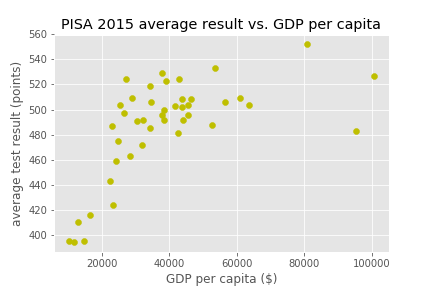

In [102]:
def show_scatterplot(df_data, variables, color, title, xlabel, ylabel):
    """Take df_data and plot for chosen columns in variables list
    :param df_data: data frame
    :param variables: list of strings
    :param color: string"""
    plt.scatter(x=df_data[variables[0]], y=df_data[variables[1]], color=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
matplotlib.style.use('ggplot')
plot_ave_gdp_ppp = show_scatterplot(pisa_ave_gdp_ppp, ['gdp_ppp', 'ave_result'], 'y',
                                    'PISA 2015 average result vs. GDP per capita', 'GDP per capita ($)',
                                    'average test result (points)')

We can see that the points in the plot are not necessarily forming a straight line, which is a reminder that we should take log of GDP data to enable linear regression analysis. It helps to make our distribution less skewed. 

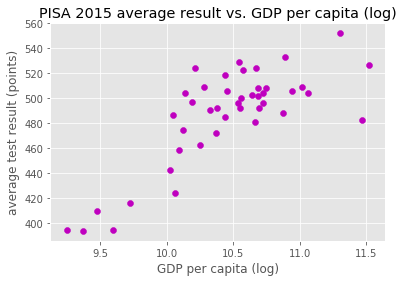

In [20]:
def take_log(df_data, columns):
    """Create a copy of df_data and take log of values from columns
    :param df_data: data frame
    :param columns: list of strings"""
    log_data = df_data.copy()
    for i in columns:
        log_data[i] = np.log(log_data[i])
        rename_columns(log_data, {i: str(i) + '_log'})
    return log_data

#take log from GDP values
pisa_ave_gdp_ppp_log = take_log(pisa_ave_gdp_ppp, ['gdp_ppp'])

#plot with GDP log
plot_ave_gdp_ppp_log = show_scatterplot(pisa_ave_gdp_ppp_log, ['gdp_ppp_log', 'ave_result'], 'm', 
                                        'PISA 2015 average result vs. GDP per capita (log)', 'GDP per capita (log)',
                                    'average test result (points)')

Now our data form something resembling straight line, but still there is one dot which seems to be an outlier from the linear model - it’s Luxembourg. It's a country that has been considered second richest in the world for many years lately. Luxembourg is a place with relative high income per capita and accoridng to Business Insider report this is due to the large number of people working in the tiny nation while living in surrounding France, Germany and Belgium (it can be even one quarter of the entire population, who are not included in GDP calculation [<a href="#source_7">7</a>]). Excluding Luxembourg from regression might seem like a good idea, that's why we will perform the analysis in two versions to compare the results.

In [21]:
#perform OLS 
model_ave_gdp_ppp_log = smf.ols(formula='ave_result ~ gdp_ppp_log', data=pisa_ave_gdp_ppp_log).fit()
model_ave_gdp_ppp_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ave_result   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     67.48
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           3.37e-10
Time:                        10:38:55   Log-Likelihood:                -196.97
No. Observations:                  43   AIC:                             397.9
Df Residuals:                      41   BIC:                             401.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -148.5283     77.392     -1.919      0.062    -304.824       7.767
gdp_ppp_log    60.7787      7.399      8.215      0.000      45.837      75.721
==============================================================================
Omnibus:                        0.557   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.240
Skew:                          -0.182   Prob(JB):                        0.887
Kurtosis:                       3.039   Cond. No.                         222.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#leave LUX out as an outlier
pisa_ave_gdp_ppp_log_lux = pisa_ave_gdp_ppp_log[pisa_ave_gdp_ppp_log['Code'] != 'LUX']

#perform OLS without Luxembourg
model_ave_gdp_ppp_log_lux = smf.ols(formula='ave_result ~ gdp_ppp_log', data=pisa_ave_gdp_ppp_log_lux).fit()
model_ave_gdp_ppp_log_lux.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ave_result   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     92.62
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           5.77e-12
Time:                        10:38:56   Log-Likelihood:                -188.14
No. Observations:                  42   AIC:                             380.3
Df Residuals:                      40   BIC:                             383.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -220.5759     73.560     -2.999      0.005    -369.245     -71.907
gdp_ppp_log    67.8394      7.049      9.624      0.000      53.592      82.086
==============================================================================
Omnibus:                        1.319   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.517   Jarque-Bera (JB):                1.292
Skew:                           0.328   Prob(JB):                        0.524
Kurtosis:                       2.444   Cond. No.                         230.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the first version the R-squared value indicate that there is a 0.62 correlation between GDP per capita and average PISA test results. When we  exclude Luxembourg from the dataset the percentage of the variables that is explained by a linear model increases to 0.70, which is still moderate.

Interpreting our model coefficients we can say that after increasing GDP per capita by 1%, the average PISA result should go up by 0.68 points.
Other important features of regression output are:
- standard error, which is an estimate of the standard deviation of the coefficient, the amount it varies across cases,
- p-value, which helps to determine the significance of the results. You get it by comparing the t statistic on your variable (the coefficient divided by its standard error) with values in the Student's t distribution
- confidence interval, which tells us where the most of our variables are distributed

Our standard error oscillate in the surroundings of +/- 7 points. We have a very small p-value, which indicates strong evidence against the null hypothesis. It means we can reject the null hypothesis that GDP per capita does not have any effect on PISA results. In other words, you can say with a 100% probability of being correct that the variable is having some effect, assuming your model is specified correctly. Examining confidence interval, we see that we can be 95% confident that the "true" GDP per capita coefficient is between 0.53 and 0.82 points.

Let's see the curve we fitted into our data using regression coefficients.


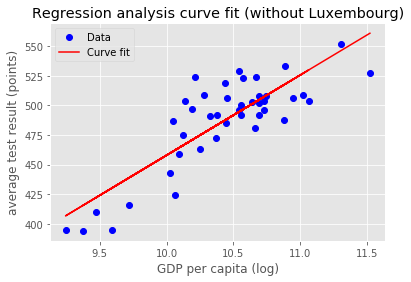

In [23]:
def fit_data_mat(df_data1, df_data2, degree, title, x_label, y_label):
    """Plot data from df_data1 and df_data2 and try to fit a curve with a given degree using matplotlib.pyplot
    :param df_data1: data frame
    :param df_data2: data frame
    :param degree: integer
    :param x_label: string
    :param y_label: string"""
    pylab.plot(df_data1, df_data2, 'bo', label='Data')
    pylab.title(title)
    pylab.xlabel(x_label)
    pylab.ylabel(y_label)
    model = pylab.polyfit(df_data1, df_data2, degree)
    est_y_vals = pylab.polyval(model, df_data1)
    pylab.plot(df_data1, est_y_vals, 'r', label='Curve fit')
    pylab.legend(loc='best')
    pylab.show()

#plot with curve
lin_ave_gdp_ppp_log_lux = fit_data_mat(pisa_ave_gdp_ppp_log_lux ['gdp_ppp_log'], pisa_ave_gdp_ppp_log_lux ['ave_result'], 1,
                                       'Regression analysis curve fit (without Luxembourg)', 'GDP per capita (log)',
                                   'average test result (points)')

Summing the first part up, we can say with a great certainty that countries' GDP per capita has some effect on it's average PISA test results. Unfortunately, even the correlation rate above 70% couldn't confirm that the relationship is causal, meaning it's still hard to say, if the wealth of the country is the reason that its students are the top performers in the assessment or it's the other way round. 

## Extracting government expenses on education per student 

The previous part of analysis showed that there is a reason to believe that students in wealthier countries reach higher scores in the assessment, meaning, they are better prepared for full participation in society. There's probably number of factors influencing the outcome, but let's take a deeper look at one more - government expenses on education. We can ask a question, does higher public expenses influence exam results positively?

Let's make an assumption that before each student sat at PISA test at the age of 15 he or she probably had spent 12 years on learning in various forms and institutions. Starting with kindergarten we can add up expenses per student according to another assumption, that every pupil spent 3 years in pre-primary institutions, 6 years in primary and then 3 more in lower- secondary. This way, we are going to calculate total cost of each student education before being evaluated. Let's first calculate yearly expenses per student on every level of education using two indicators:
- Goverment expenditure on education in PPP $ from <a href="http://data.uis.unesco.org/">UNESCO database</a>
- Population of the official age (both sexes) form World Bank API 

In [105]:
def read_csv_data_by_list(file, codes_list):
    """Read in a file from pisaprojectdatafiles directory and select rows with countries codes from codes_list
    :param file: string
    :param codes_list: list
    :returns: df_data: data frame"""
    df = pd.read_csv('../data_files/{0}'.format(file))
    df_data = pd.DataFrame()
    for i in codes_list:
        df_data = df_data.append(df.loc[df['LOCATION'] == i], ignore_index=True)
    return df_data

#read in file for given countries (source UNESCO database)
gov_edu_expenses = read_csv_data_by_list('gov_exp_edu_ppp.csv', countries_codes)

In [106]:
gov_edu_expenses.head()

,EDULIT_IND,Indicator,LOCATION,Country,TIME,Time,Value,Flag Codes,Flags
0,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2000,2000,24725.62465,NaN,NaN
1,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2005,2005,32622.18048,NaN,NaN
2,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2006,2006,33710.66280,NaN,NaN
3,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2007,2007,35497.95717,NaN,NaN
4,X_PPP_FSGOV,"Government expenditure on education, PPP$ (mil...",AUS,Australia,2008,2008,36915.62215,NaN,NaN


Let's do some cleaning. First we need to filter only rows with expenses for 3 levels of education, we are interested in. Then we will drop a few irrelevant columns. 

In [53]:
def filter_by_indicator(df_data, indicators):
    """Take df_data and select rows for given indicators, then append it to df_data_ind
    :param df_data: data frame
    :param indicators: list"""
    df_data_ind = pd.DataFrame()
    for i in indicators:
        df_data_ind = df_data_ind.append(df_data.loc[df_data['EDULIT_IND'] == i], ignore_index=True)
    return df_data_ind

#select indicators: pre-primary, primary and lower secondary
basic_edu_exp = filter_by_indicator(gov_edu_expenses, ['X_PPP_02_FSGOV', 'X_PPP_1_FSGOV', 'X_PPP_2_FSGOV'])

def drop_columns(df_data, del_col):
    """Take df_data and drop del_col columns from it
    :param df_data: data frame
    :param del_col: list"""
    for i in del_col:
        df_data.drop(i, axis=1, inplace=True)

#drop unnecessary column
drop_columns(basic_edu_exp, ['TIME', 'Flag Codes', 'Flags'])

In [54]:
basic_edu_exp.head()

,EDULIT_IND,Indicator,LOCATION,Country,Time,Value
0,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2000,305.81718
1,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2005,337.80961
2,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2006,343.28577
3,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2007,329.08133
4,X_PPP_02_FSGOV,Government expenditure on pre-primary educatio...,AUS,Australia,2008,344.47252


In order to get columns with labels for each level of education we are going to pivot the table. We are get a data frame with multiIndex as a side effect, but we can easily reset the index in the next step. Lastly we will rearrange columns order and add new column with country code to improve readability. 

In [55]:
#pivot df to get similar structure like student_count_data
basic_edu_exp = basic_edu_exp.pivot_table('Value', ['Country', 'Time'], 'EDULIT_IND')

#reset multiindex "Country' and 'Time'
basic_edu_exp.reset_index(level=['Country', 'Time'], inplace=True)

#rename column labels
rename_columns(basic_edu_exp,
                {'X_PPP_02_FSGOV': 'pre_primary_exp', 'X_PPP_1_FSGOV': 'primary_exp', 'X_PPP_2_FSGOV': 'lower_sec_exp'})

#add new column with country code
basic_edu_exp = add_country_code(basic_edu_exp, name_code_dict)

In [56]:
basic_edu_exp.head()

EDULIT_IND,Country,Code,Time,pre_primary_exp,primary_exp,lower_sec_exp
0,Australia,AUS,2000,305.81718,8423.50480,5516.02444
1,Australia,AUS,2005,337.80961,11295.30178,7416.54158
2,Australia,AUS,2006,343.28577,11788.02032,7627.92380
3,Australia,AUS,2007,329.08133,12474.39018,7929.35300
4,Australia,AUS,2008,344.47252,13076.70412,8567.19040


Once we have global expenses on education, let's look for the number of students on each level in a given year. We're going to use population of the official age indicator, because it tells how many children were suitable for every level of education in a given year. It's just an approximation of the real number of students who attended to schools, but due to lack of entries in other data sets it is still quite informative. 

In [57]:
#read in file with student count for given countries
edu_indicators = {'SP.PRE.TOTL.IN':'pre_primary_pop', 'SP.PRM.TOTL.IN':'primary_pop', 'SP.SEC.LTOT.IN':'lower_sec_pop'}
basic_student_pop = load_from_wbdata(countries_codes, edu_indicators, 2003, 2014)

In [58]:
basic_student_pop.head()

lower_sec_pop  pre_primary_pop  primary_pop
country   date                                             
Australia 2014      1131485.0         312992.0    2044324.0
          2013      1135749.0         306122.0    1996598.0
          2012      1138769.0         296675.0    1956838.0
          2011      1139426.0         286667.0    1926646.0
          2010      1135116.0         277605.0    1906281.0

Again, we need to perform some minor cleaning like reseting the multiIndex or unifying labels.

In [59]:
#reset multiindex
basic_student_pop.reset_index(level=['country', 'date'], inplace=True)

#rename column labels
rename_columns(basic_student_pop, {'country': 'Country', 'date': 'Time'})

#change column order
basic_student_pop = basic_student_pop[['Country', 'Time', 'pre_primary_pop', 'primary_pop', 'lower_sec_pop']]

#add new column with country code
basic_student_pop = add_country_code(basic_student_pop, name_code_dict)

In [60]:
basic_student_pop.head()

,Country,Code,Time,pre_primary_pop,primary_pop,lower_sec_pop
0,Australia,AUS,2014,312992.0,2044324.0,1131485.0
1,Australia,AUS,2013,306122.0,1996598.0,1135749.0
2,Australia,AUS,2012,296675.0,1956838.0,1138769.0
3,Australia,AUS,2011,286667.0,1926646.0,1139426.0
4,Australia,AUS,2010,277605.0,1906281.0,1135116.0


To finally get government expenses per student we need to convert 'Time' column data type to enable further merging. We are going to merge the frames with 'right' method, because we want to stay with data only for years 2003-2014. After that we do the division and clean our data frame.

In [62]:
#convert 'Time' column type to int
basic_edu_exp['Time'] = basic_edu_exp['Time'].apply(np.int16)
basic_student_pop['Time'] = basic_student_pop['Time'].apply(np.int16)

#merge expenses and population, right method to stay with 2003-2014 period
edu_data_joined = pd.merge(basic_edu_exp, basic_student_pop, how='right', on=['Code', 'Time'])

#sort by 'Code' and 'Time' and reset index
edu_data_joined.sort_values(['Code', 'Time'], ascending=[True, True], inplace=True)
edu_data_joined.reset_index(level=0, drop=True, inplace=True)

In [73]:
edu_data_joined.head()

,Country_x,Code,Time,pre_primary_exp,primary_exp,lower_sec_exp,Country_y,pre_primary_pop,primary_pop,lower_sec_pop
0,NaN,AUS,2003,NaN,NaN,NaN,Australia,257635.0,1907497.0,1097962.0
1,NaN,AUS,2004,NaN,NaN,NaN,Australia,255782.0,1898867.0,1112812.0
2,Australia,AUS,2005,337.80961,11295.30178,7416.54158,Australia,256984.0,1889791.0,1128626.0
3,Australia,AUS,2006,343.28577,11788.02032,7627.92380,Australia,257829.0,1882189.0,1142895.0
4,Australia,AUS,2007,329.08133,12474.39018,7929.35300,Australia,260173.0,1879753.0,1145741.0


In [76]:
def divide_col_by_col(df_data, dividends, divisors):
    """Takes df_data and divides columns accordingly by rule dividends/divisors,
    returns df_data_div only with divided columns
    :param df_data: data frame
    :param dividends: list of column labels
    :param divisors: list of column labels
    :returns: df_data_div: data frame
    """
    df_data_div = df_data.copy()
    for n in range(len(dividends)):
        df_data_div[n] = df_data_div[dividends[n]] / df_data_div[divisors[n]] * 1000000
    df_data_div.round(0)
    drop_columns(df_data_div, [dividends + divisors])
    drop_columns(df_data_div, ['Country_y'])
    rename_columns(df_data_div, {'Country_x': 'Country', 0: 'pre_primary_per_student',
                                          1: 'primary_per_student', 2: 'lower_sec_per_student'})
    return df_data_div

#divide total expenses by number of students
edu_data_per_student = divide_col_by_col(edu_data_joined, ['pre_primary_exp', 'primary_exp', 'lower_sec_exp'],
                                         ['pre_primary_pop', 'primary_pop', 'lower_sec_pop'])

In [77]:
edu_data_per_student.head()

,Country,Code,Time,pre_primary_per_student,primary_per_student,lower_sec_per_student
0,NaN,AUS,2003,NaN,NaN,NaN
1,NaN,AUS,2004,NaN,NaN,NaN
2,Australia,AUS,2005,1314.516118,5977.011098,6571.301370
3,Australia,AUS,2006,1331.447471,6262.931257,6674.212242
4,Australia,AUS,2007,1264.855807,6636.185807,6920.720302


As we see NaN values started to occur and using .isnull() method we can check that there's more of them in the whole data frame. There are a few ways to deal with those lacks, but in this case it seems reasonable to make a use of Python build in function called <a href="https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate"> interpolate</a>. In order not to fill the gaps, where we don't have enough information let's make an assumption. For every country in the dataset first check the number of NaN in a given period we are interested in, for example years 2003-2005 for pre-primary education. If any lack occurs, examine the whole column for a given level of education. If the ratio of NaN is below 50% we will interpolate for the whole column, in other cases we will drop the country. 

In [79]:
def estimate_total_cost(df_data):
    """Takes df_data and estimates total cost per student during 12 years of education
    :param df_data: data frame
    :returns total_cost: total_cost df with country Code and total cost"""
    total_cost = pd.DataFrame(columns=['Code', 'Total'])
    country_list = df_data.Code.unique()
    for country in country_list:
        country_df = df_data.loc[df_data['Code'] == country].copy()
        cost_pre_primary = sum_col(country_df, 0, 3, 'pre_primary_per_student')
        cost_primary = sum_col(country_df, 3, 9, 'primary_per_student')
        cost_second = sum_col(country_df, 9, 12, 'lower_sec_per_student')
        cost_temp = [cost_pre_primary, cost_primary, cost_second]
        for i in cost_temp:
            if i > 0:
                sum_temp = sum(cost_temp)
            else:
                sum_temp = 0
        total_cost = total_cost.append(pd.DataFrame([[country, sum_temp]], columns=['Code', 'Total']),
                                               ignore_index=True)
    return total_cost

def sum_col(country_df, index_start, index_end, label):
    """Helper function for estimate_total_cost, which calculate total cost for a single country
    :param country_df: data frame
    :param index_start: integer
    :param index_end: integer
    :param label: string
    :returns col_sum: integer"""
    test_col = country_df[index_start:index_end][label]
    small_ratio = test_col.isnull().sum() / len(test_col.index)
    big_ratio = country_df[label].isnull().sum() / len(country_df.index)
    if small_ratio > 0:
        if big_ratio < 0.5:
            country_df.loc[:,label].interpolate(limit_direction='both', inplace=True)
            col_sum = sum(test_col)
        else:
            col_sum = 0
    else:
        col_sum = sum(test_col)
    return col_sum

#estimate total expenses per student in a given country
student_total_expenses = estimate_total_cost(edu_data_per_student)

As a result of our assumption we had to get rid of 10 countries from the original dataset. 

In [81]:
#delete countries with zero data ([CAN, GRC, HKG, MAC, OAVG, SGP, TUR] [ISR, PER, SVN])
student_total_expenses = student_total_expenses[student_total_expenses.Total != 0]

#reset index
student_total_expenses.reset_index(drop=True, inplace=True)

#add column with country name
add_country_name(student_total_expenses, code_name_dict)

In [82]:
#show values in descending order
student_total_expenses.sort_values(['Total'], ascending=False)

,Country,Code,Total
21,Luxembourg,LUX,200673.535739
3,Switzerland,CHE,136036.662136
8,Denmark,DNK,117633.540538
25,Norway,NOR,115857.985802
1,Austria,AUT,115410.228919
24,Netherlands,NLD,114575.350098
30,Sweden,SWE,110162.348107
31,United States of America,USA,104441.889370
17,Iceland,ISL,103571.305077
13,United Kingdom of Great Britain and Northern I...,GBR,95985.177377


## Regression analysis for average PISA results and govermnent expenses on education per student 

Our last step is again regression analysis to check if there is ant relevant correlation between two variables. Let's merge data frames first and check the scatterplot. 

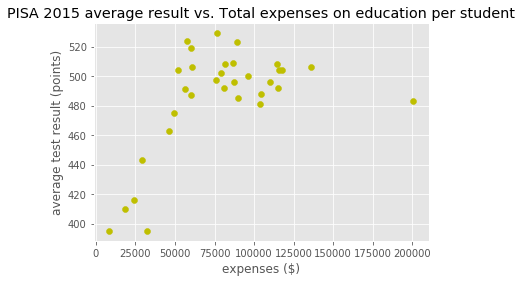

In [84]:
#merge with average PISA results
pisa_ave_expenses = merge_df_onCode(all_pisa_2015_ave, student_total_expenses)

#plot
plot_ave_expenses = show_scatterplot(pisa_ave_expenses, ['Total', 'ave_result'], 'y',
                                     'PISA 2015 average result vs. Total expenses on education per student',
                                     'expenses ($)', 'average test result (points)')

As we see, we're going to need our previous tricks to make the data more 'linear regression friendly'. Let's first take log of expenses values and make another plot.

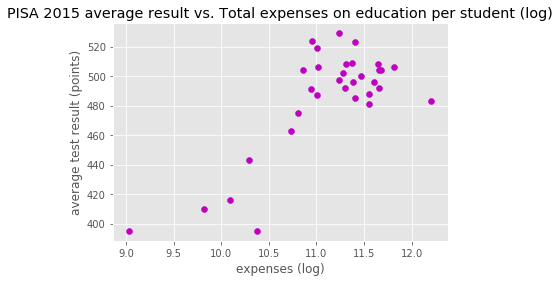

In [85]:
#take log from expenses
pisa_ave_expenses_log = take_log(pisa_ave_expenses, ['Total'])

#plot with expenses log
plot_ave_expenses_log = show_scatterplot(pisa_ave_expenses_log, ['Total_log', 'ave_result'], 'm',
                                        'PISA 2015 average result vs. Total expenses on education per student (log)',
                                         'expenses (log)', 'average test result (points)')

This time it seems that there might be even another outlier apart from Luxembourg - it's Brazil. It has relatively low PISA results for a country with such expenses on education. It may be a sign of some ineffectiveness in education system, but let's not go to far with the interpretation. 

In [89]:
#leave LUX out as an outlier
pisa_ave_expenses_log_lux = pisa_ave_expenses_log[pisa_ave_expenses_log['Code'] != 'LUX']

#leave BRA out as an outlier
pisa_ave_expenses_log_lux_bra = pisa_ave_expenses_log_lux[pisa_ave_expenses_log_lux['Code'] != 'BRA']

In [90]:
#perform OLS
model_ave_expenses_log_lux_bra = smf.ols(formula='ave_result ~ Total_log', data=pisa_ave_expenses_log_lux_bra).fit()

#show summary
model_ave_expenses_log_lux_bra.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ave_result   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     58.42
Date:                Tue, 21 Nov 2017   Prob (F-statistic):           2.51e-08
Time:                        14:03:21   Log-Likelihood:                -129.87
No. Observations:                  30   AIC:                             263.7
Df Residuals:                      28   BIC:                             266.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0043     63.603      0.047      0.963    -127.281     133.290
Total_log     43.7164      5.719      7.643      0.000      32.001      55.432
==============================================================================
Omnibus:                        2.445   Durbin-Watson:                   2.297
Prob(Omnibus):                  0.295   Jarque-Bera (JB):                2.133
Skew:                           0.625   Prob(JB):                        0.344
Kurtosis:                       2.620   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All the adjustments in the data again resulted in increased correlation value - from 0,31 to 0,68 points. Interpreting our model coefficients we can say that after increasing government expenses per student by 1%, the average PISA result should go up by 0.68 points.

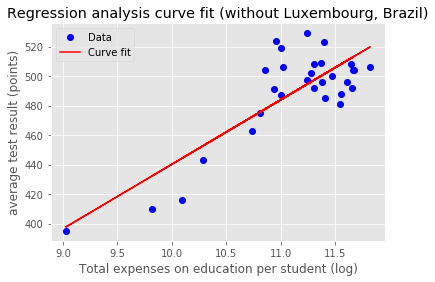

In [91]:
lin_ave_expenses_log_lux_bra = fit_data_mat(pisa_ave_expenses_log_lux_bra['Total_log'], pisa_ave_expenses_log_lux_bra['ave_result'], 1,
                                       'Regression analysis curve fit (without Luxembourg, Brazil)',
                                        'Total expenses on education per student (log)', 'average test result (points)')

We see that after excluding some countries our data fit nicely in the calculated line. There is also another specific thing about this plot, it seems like we have a group of countries centralised around the point with 500 PISA points and 11,5 expenses, while the others, with less spending form a line. It raises a question, is it possible that after reaching some point of expenses per student we do not see to much difference in the assessment score? 

## Summary

Wrapping all the conclusions, we can say that there is a moderate positive relationship between PISA performance and country GDP per capita. This is not only a mattaer of potential, because analyzing real expenses on education gave us the same conclusion. Even though richer countries and those that allocate more resources in education score better, it's still impossible to state the direction of the relation. It may be that the wealth of the country is the reason for high score or it's the situation, where an effective education system produce smart people, who pursue to increasing their country income. The sample analyzed in the text was also not big enough to draw strong conclusions about the relation. The education effectivness itself could be maseured differently. 

The analysis leaves us with more questions than answers, that is one of the reasons I decided to make a second part of it. There are probably numbers of factors worth analysing in context of PISA performance. We could try some unsupervised learning using clustering methods to identify other relations, which may not seem so obvious. We could check correlation strength of many of them and choose only the most relevant. Then we could try fitting polynomial of different degrees and cross-validate them to check the prediction power of tested models. I hope you enjoyed my work and I'm looking forward to describing the results soon!

## Sources:
- <p id="source_1">[1] http://www.oecd.org/pisa/pisa-2015-results-in-focus.pdf</p>
- [2] https://data.oecd.org/pisa/reading-performance-pisa.htm#indicator-chart
OECD (2017), Reading performance (PISA) (indicator). doi: 10.1787/79913c69-en (Accessed on 11 September 2017)
- [3] https://data.oecd.org/pisa/mathematics-performance-pisa.htm#indicator-chart
OECD (2017), Mathematics performance (PISA) (indicator). doi: 10.1787/04711c74-en (Accessed on 11 September 2017)
- [4] https://data.oecd.org/pisa/science-performance-pisa.htm#indicator-chart
OECD (2017), Science performance (PISA) (indicator). doi: 10.1787/91952204-en (Accessed on 11 September 2017)
- [5] https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-api-documentation
- <p id="source_6">[6] http://dss.princeton.edu/online_help/analysis/interpreting_regression.htm</p>
- <p id="source_7">[7] http://www.businessinsider.com/the-23-richest-countries-in-the-world-2015-7?IR=T</p>
- [8] http://data.uis.unesco.org/